In [1]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

import sklearn
sklearn.set_config(transform_output="pandas")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

In [4]:
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [5]:
df = pd.read_csv('/kaggle/input/predicting-students-mark/student_performance_prediction_dataset.csv')

# STEP 1: DATASET SANITY CHECK

In [6]:
# 1. Missing Values
missing = df.isnull().sum().sum()
print(f"Missing Values: {missing}")

Missing Values: 0


In [7]:
# 2. Target Range (sanity check for exam_score)
min_score = df['exam_score'].min()
max_score = df['exam_score'].max()
print(f"Target Range: {min_score} to {max_score}")
if min_score < 0 or max_score > 100:
    print("FATAL: Target variable out of bounds (0-100)!")

Target Range: 19.9 to 100.0


# STEP 2: IDENTIFY FEATURE TYPES

In [8]:
target_col = 'exam_score'
drop_cols = ['id'] 
categorical_cols = ['gender', 'course', 'internet_access', 'study_method', 'exam_difficulty']
numerical_cols = [
    'age', 'study_hours', 'class_attendance', 'assignment_submission_rate', 
    'failures', 'parent_education', 'sleep_hours', 'sleep_quality', 
    'social_life_index', 'facility_rating'
]

feature_cols = [c for c in df.columns if c not in [target_col] + drop_cols]
print(f"Numerical Features ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical Features ({len(categorical_cols)}): {categorical_cols}")
df_clean = df.drop(columns=drop_cols)

Numerical Features (10): ['age', 'study_hours', 'class_attendance', 'assignment_submission_rate', 'failures', 'parent_education', 'sleep_hours', 'sleep_quality', 'social_life_index', 'facility_rating']
Categorical Features (5): ['gender', 'course', 'internet_access', 'study_method', 'exam_difficulty']


# STEP 3: EDA - Synthetic Risk Assessment

**Feature-Target Correlation**

1. This measures how strongly each feature is related to the target.
2. Synthetic data often produces unrealistically strong correlations.
3. Find which features genuinely drive predictions and whether leakage/artifacts exist.

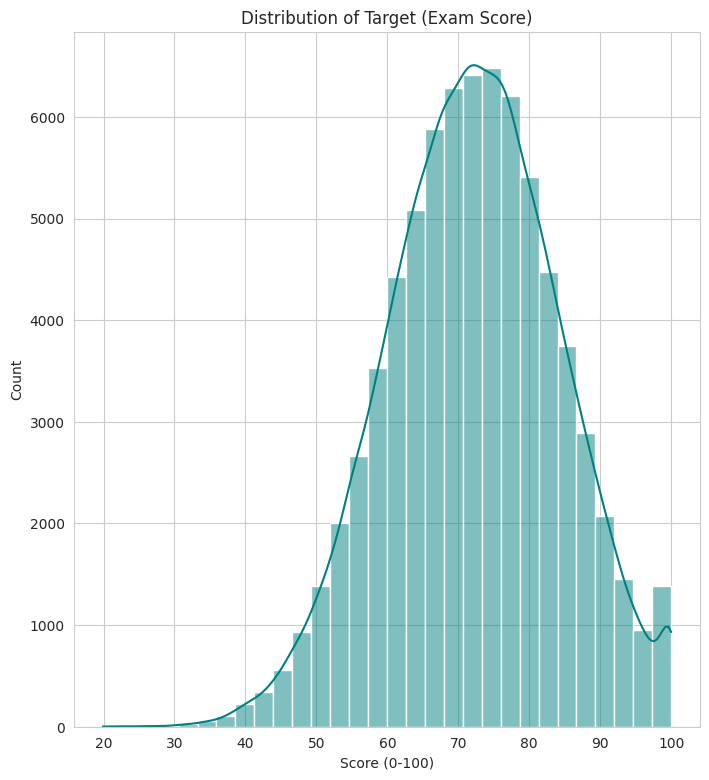

In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))

# 1. Target Distribution 
plt.subplot(2, 3, 1)
sns.histplot(df['exam_score'], kde=True, color='teal', bins=30)
plt.title('Distribution of Target (Exam Score)')
plt.xlabel('Score (0-100)')
plt.tight_layout()
plt.show()

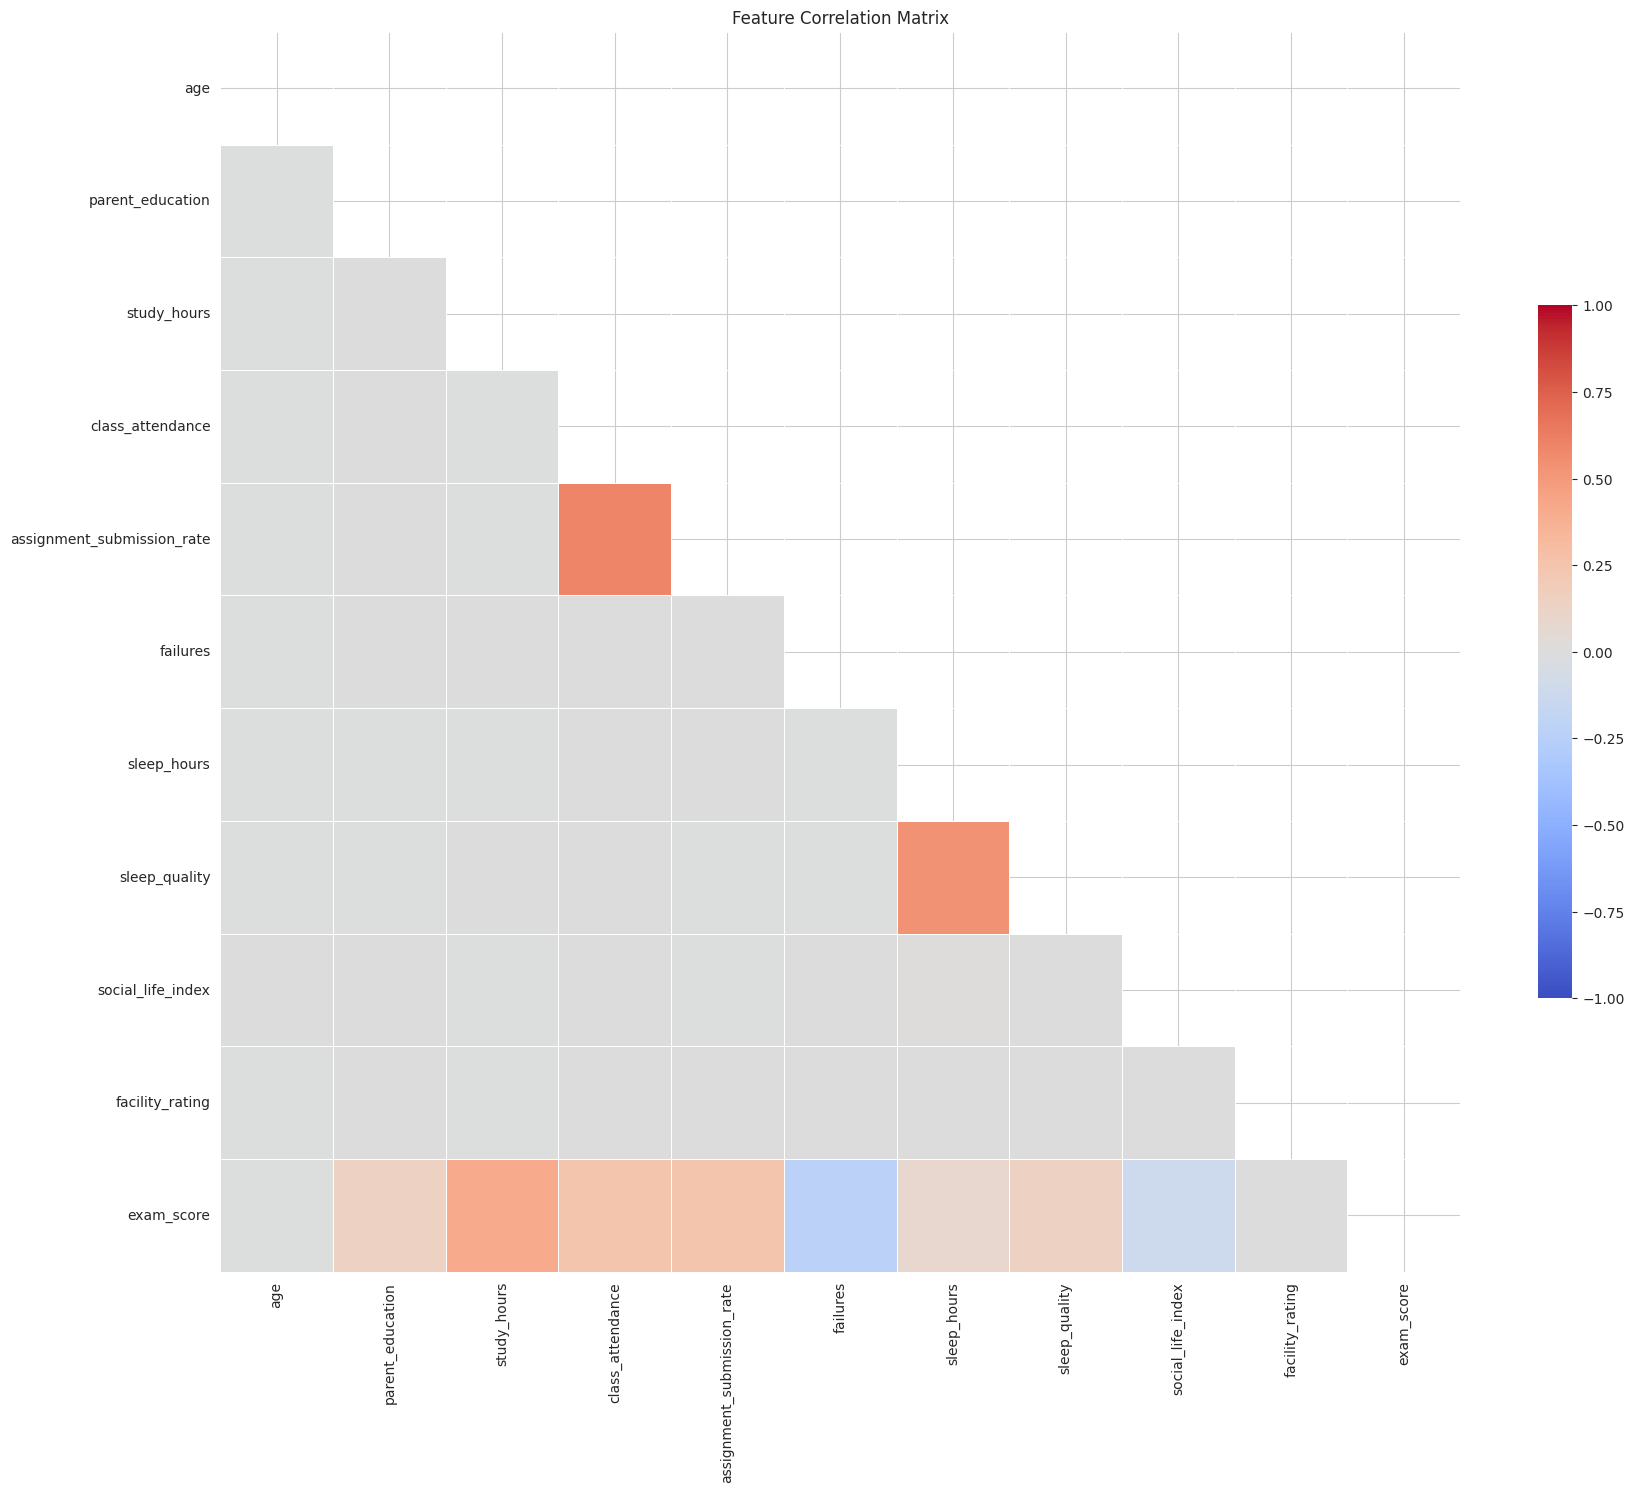

In [10]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

sns.set_style("whitegrid")
plt.figure(figsize=(20, 18)) 
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
corr = corr.astype(float)
corr.replace([np.inf, -np.inf], np.nan, inplace=True)
corr.fillna(0, inplace=True)
corr = corr.clip(-1, 1)

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', 
            vmin=-1, vmax=1, center=0,  
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Matrix')
plt.show()

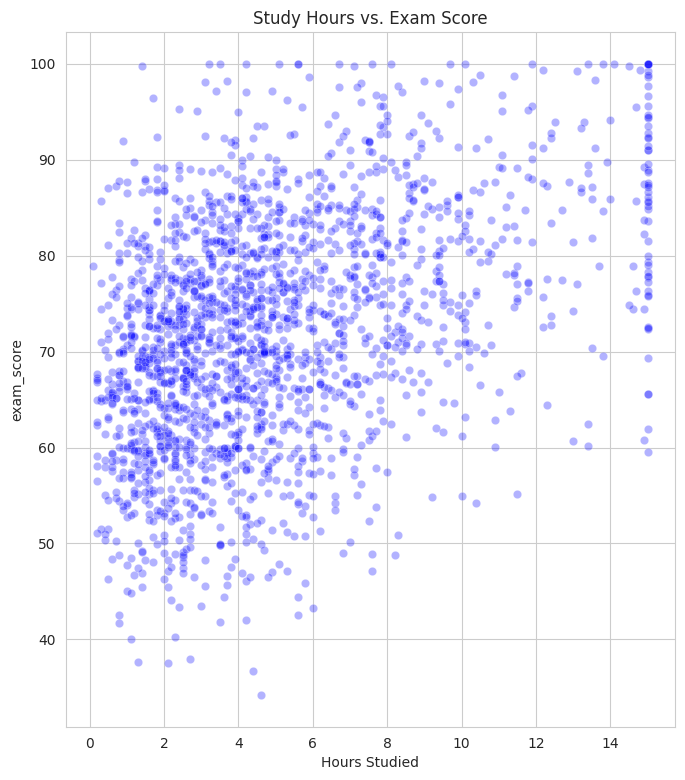

In [11]:
# 3. Study Hours vs Score 
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 3)
sns.scatterplot(x='study_hours', y='exam_score', data=df.sample(2000), alpha=0.3, color='blue')
plt.title('Study Hours vs. Exam Score')
plt.xlabel('Hours Studied')
plt.tight_layout()
plt.show()

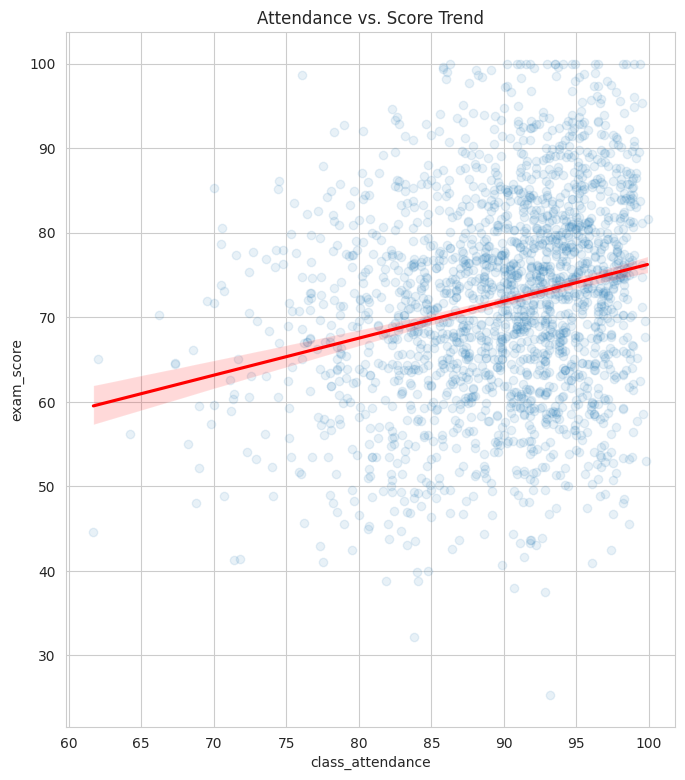

In [12]:
# 4. Attendance vs Score 
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 5)
sns.regplot(x='class_attendance', y='exam_score', data=df.sample(2000), 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Attendance vs. Score Trend')
plt.tight_layout()
plt.show()

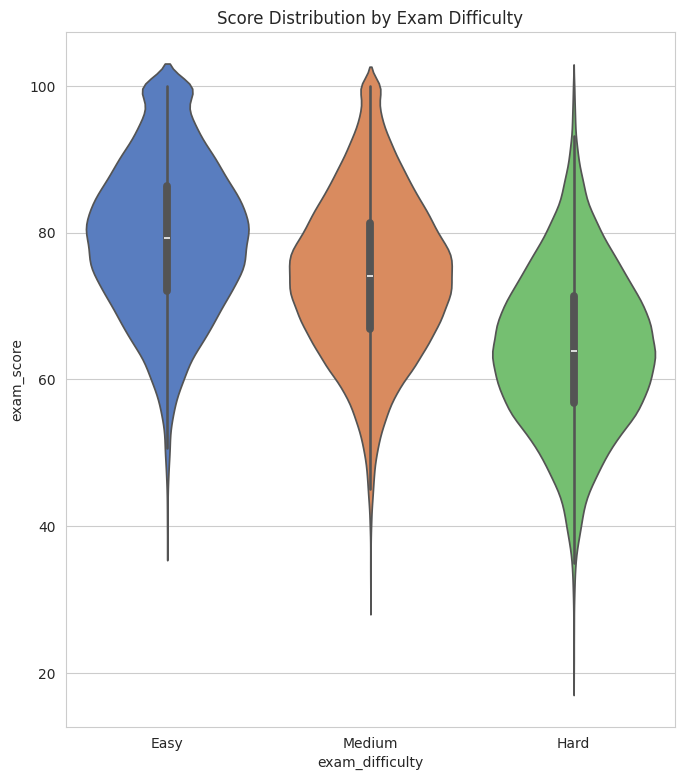

In [13]:
# 5. Categorical Check: Course Difficulty
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 6)
sns.violinplot(x='exam_difficulty', y='exam_score', data=df, order=['Easy', 'Medium', 'Hard'], palette='muted')
plt.title('Score Distribution by Exam Difficulty')

plt.tight_layout()
plt.show()

# STEP 4: Train/Validation Strategy

In [14]:
print("CV STRATEGY")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("Setup 5-Fold Cross-Validation (Shuffle=True)")

CV STRATEGY
Setup 5-Fold Cross-Validation (Shuffle=True)


# STEP 5: Preprocessing Setup

In [15]:
# TWO preprocessors: one for Linear (scaled), one for Trees (unscaled)

# 1. Linear Preprocessor (Ridge/Lasso)
# Must Standardize numericals + OneHot encode categoricals
linear_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
])

# 2. Tree Preprocessor (XGB/LGBM)
# No scaling needed. Ordinal Encoding usually suffices and keeps dimensionality low.
tree_preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
])

# STEP 6: Model Training

In [16]:
# We must set sparse_output=False for OneHotEncoder to work with Pandas output
linear_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_cols)
], verbose_feature_names_out=False)

# Tree preprocessor 
tree_preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
], verbose_feature_names_out=False)

In [17]:
print("MODEL TRAINING & EVALUATION")

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

results = {}
def evaluate_model(name, model, preprocessor, X, y, kf):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_scores = -scores
    
    print(f"\n>> {name}")
    print(f"   CV RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    return pipeline, rmse_scores.mean()

# 1. Ridge Regression (Baseline)
ridge_model = Ridge(alpha=1.0)
pipe_ridge, ridge_score = evaluate_model("Ridge Regression", ridge_model, linear_preprocessor, X, y, kf)
results['Ridge'] = ridge_score

# 2. Lasso Regression (Feature Pruning)
lasso_model = Lasso(alpha=0.01) 
pipe_lasso, lasso_score = evaluate_model("Lasso Regression", lasso_model, linear_preprocessor, X, y, kf)
results['Lasso'] = lasso_score

# Check Zero Coefficients
pipe_lasso.fit(X, y) 
lasso_coefs = pipe_lasso.named_steps['model'].coef_
zero_coefs = np.sum(lasso_coefs == 0)
print(f"   [Lasso Pruning] Dropped {zero_coefs} features (Coefficients = 0).")

# 3. LightGBM (Main Model)
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10, 
    num_leaves=31,
    random_state=42,
    verbose=-1
)
pipe_lgbm, lgbm_score = evaluate_model("LightGBM", lgbm_model, tree_preprocessor, X, y, kf)
results['LightGBM'] = lgbm_score

# 4. XGBoost (Confirmation)
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
pipe_xgb, xgb_score = evaluate_model("XGBoost", xgb_model, tree_preprocessor, X, y, kf)
results['XGBoost'] = xgb_score

MODEL TRAINING & EVALUATION

>> Ridge Regression
   CV RMSE: 7.9205 ± 0.0306

>> Lasso Regression
   CV RMSE: 7.9207 ± 0.0307
   [Lasso Pruning] Dropped 6 features (Coefficients = 0).

>> LightGBM
   CV RMSE: 8.0352 ± 0.0244

>> XGBoost
   CV RMSE: 8.0972 ± 0.0285


In [18]:
pipe_lgbm.fit(X, y)
importances = pipe_lgbm.named_steps['model'].feature_importances_
feature_names = numerical_cols + categorical_cols

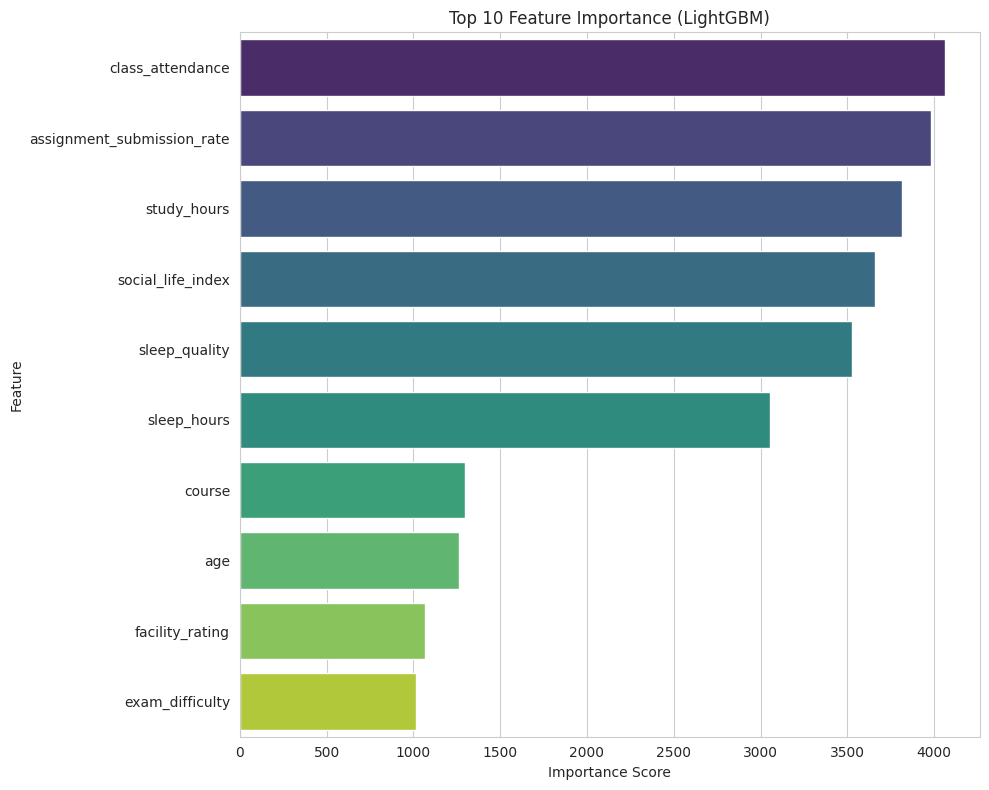

In [19]:
plt.figure(figsize=(10, 8)) 
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Top 10 Feature Importance (LightGBM)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Result Comparision

In [20]:
print("FINAL COMPARISON")
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))
for name, score in sorted_results.items():
    print(f"{name}: {score:.4f} RMSE")

FINAL COMPARISON
Ridge: 7.9205 RMSE
Lasso: 7.9207 RMSE
LightGBM: 8.0352 RMSE
XGBoost: 8.0972 RMSE


In [21]:
test_df = pd.read_csv('/kaggle/input/predicting-students-mark/test.csv') 

submission_ids = test_df['id']
X_test = test_df.drop(columns=['id'], errors='ignore')

try:
    predictions = pipe_lgbm.predict(X_test)
    submission = pd.DataFrame({
        'id': submission_ids,
        'exam_score': predictions
    })
    submission.to_csv('submissions.csv', index=False)
    print("Submission saved successfully")

except Exception as e:
    print(f"Error occurred: {e}")

Submission saved successfully
